In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [3]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = data_per_word * len(words)
timesteps = 50
dimensions = 22

In [4]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [5]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [6]:
pick_frame_every_no = max_frame / 50 + 1

In [7]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.array([])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[word_no * data_per_word + data_no, curr_idx, :] = feature
            curr_idx += 1

        y = np.append(y, word_no)

In [8]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [9]:
x_train = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 / 3])
x_test = np.zeros([data_length / 3, timesteps, dimensions])
y_test = np.zeros([data_length / 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx / 3] = x_norm[idx]
        y_test[idx / 3] = y[idx]
    else:
        x_train[idx - idx / 3] = x_norm[idx]
        y_train[idx - idx / 3] = y[idx]

In [10]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 / 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [11]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [12]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 342 samples, validate on 171 samples
Epoch 1/1000
342/342 [==============================] - 5s 16ms/step - loss: 3.0119 - acc: 0.0351 - val_loss: 2.9464 - val_acc: 0.0526
Epoch 2/1000
342/342 [==============================] - 2s 6ms/step - loss: 2.9630 - acc: 0.0468 - val_loss: 2.9583 - val_acc: 0.0643
Epoch 3/1000
342/342 [==============================] - 2s 7ms/step - loss: 2.9860 - acc: 0.0439 - val_loss: 2.9487 - val_acc: 0.0585
Epoch 4/1000
342/342 [==============================] - 4s 12ms/step - loss: 2.9712 - acc: 0.0760 - val_loss: 2.9486 - val_acc: 0.0175
Epoch 5/1000
342/342 [==============================] - 3s 10ms/step - loss: 2.9951 - acc: 0.0643 - val_loss: 2.8558 - val_acc: 0.1053
Epoch 6/1000
342/342 [==============================] - 3s 9ms/step - loss: 2.9277 - acc: 0.0643 - val_loss: 2.7828 - val_acc: 0.1404
Epoch 7/1000
342/342 [==============================] - 3s 8ms/step - loss: 2.9506 - acc: 0.0760 - val_loss: 2.9118 - val_acc: 0.0702
Epoch 8/1000


342/342 [==============================] - 2s 5ms/step - loss: 1.9837 - acc: 0.2456 - val_loss: 1.7070 - val_acc: 0.3977
Epoch 62/1000
342/342 [==============================] - 2s 5ms/step - loss: 1.9253 - acc: 0.2895 - val_loss: 1.7908 - val_acc: 0.3684
Epoch 63/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.8607 - acc: 0.2924 - val_loss: 1.7241 - val_acc: 0.4035
Epoch 64/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.7613 - acc: 0.3275 - val_loss: 1.7365 - val_acc: 0.3509
Epoch 65/1000
342/342 [==============================] - 3s 8ms/step - loss: 1.8021 - acc: 0.3246 - val_loss: 1.8119 - val_acc: 0.3860
Epoch 66/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.8341 - acc: 0.3099 - val_loss: 1.7259 - val_acc: 0.4152
Epoch 67/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.8763 - acc: 0.2807 - val_loss: 1.6815 - val_acc: 0.4035
Epoch 68/1000
342/342 [==============================] - 2s 6ms/step 

342/342 [==============================] - 2s 6ms/step - loss: 1.6523 - acc: 0.4269 - val_loss: 1.4744 - val_acc: 0.4912
Epoch 122/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.5112 - acc: 0.3918 - val_loss: 1.4202 - val_acc: 0.5731
Epoch 123/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.5282 - acc: 0.4094 - val_loss: 1.4682 - val_acc: 0.5439
Epoch 124/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.6411 - acc: 0.4035 - val_loss: 1.4728 - val_acc: 0.5205
Epoch 125/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.4117 - acc: 0.4708 - val_loss: 1.4800 - val_acc: 0.4971
Epoch 126/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.4612 - acc: 0.4181 - val_loss: 1.4426 - val_acc: 0.5088
Epoch 127/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.4677 - acc: 0.4181 - val_loss: 1.4464 - val_acc: 0.5439
Epoch 128/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 6ms/step - loss: 1.2777 - acc: 0.5058 - val_loss: 1.3792 - val_acc: 0.5965
Epoch 182/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.2525 - acc: 0.5380 - val_loss: 1.3865 - val_acc: 0.5789
Epoch 183/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.4282 - acc: 0.4737 - val_loss: 1.3861 - val_acc: 0.5556
Epoch 184/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.2624 - acc: 0.5175 - val_loss: 1.3838 - val_acc: 0.5322
Epoch 185/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.3246 - acc: 0.5117 - val_loss: 1.4219 - val_acc: 0.5789
Epoch 186/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.2984 - acc: 0.4912 - val_loss: 1.4016 - val_acc: 0.5614
Epoch 187/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.2895 - acc: 0.4766 - val_loss: 1.3899 - val_acc: 0.6199
Epoch 188/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 6ms/step - loss: 1.1711 - acc: 0.5702 - val_loss: 1.2265 - val_acc: 0.6374
Epoch 242/1000
342/342 [==============================] - 2s 7ms/step - loss: 1.1990 - acc: 0.5556 - val_loss: 1.2060 - val_acc: 0.6550
Epoch 243/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.0772 - acc: 0.5906 - val_loss: 1.1689 - val_acc: 0.6374
Epoch 244/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.1348 - acc: 0.5702 - val_loss: 1.2137 - val_acc: 0.6316
Epoch 245/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.1711 - acc: 0.5585 - val_loss: 1.2308 - val_acc: 0.6550
Epoch 246/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.1244 - acc: 0.5702 - val_loss: 1.2040 - val_acc: 0.6491
Epoch 247/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.1690 - acc: 0.5819 - val_loss: 1.2359 - val_acc: 0.6374
Epoch 248/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 6ms/step - loss: 1.0752 - acc: 0.5965 - val_loss: 1.2153 - val_acc: 0.6667
Epoch 302/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9900 - acc: 0.6287 - val_loss: 1.2000 - val_acc: 0.6725
Epoch 303/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.0655 - acc: 0.5936 - val_loss: 1.1822 - val_acc: 0.6784
Epoch 304/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9584 - acc: 0.6111 - val_loss: 1.1741 - val_acc: 0.6901
Epoch 305/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9518 - acc: 0.6550 - val_loss: 1.2081 - val_acc: 0.7018
Epoch 306/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9969 - acc: 0.6404 - val_loss: 1.1896 - val_acc: 0.6667
Epoch 307/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.0580 - acc: 0.6140 - val_loss: 1.2091 - val_acc: 0.6842
Epoch 308/1000
342/342 [==============================] - 3s 9m

342/342 [==============================] - 2s 6ms/step - loss: 0.9250 - acc: 0.6901 - val_loss: 1.2534 - val_acc: 0.7135
Epoch 362/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8774 - acc: 0.6871 - val_loss: 1.2607 - val_acc: 0.7193
Epoch 363/1000
342/342 [==============================] - 3s 7ms/step - loss: 1.0461 - acc: 0.6257 - val_loss: 1.2466 - val_acc: 0.6901
Epoch 364/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9967 - acc: 0.6111 - val_loss: 1.2625 - val_acc: 0.6725
Epoch 365/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.0083 - acc: 0.6550 - val_loss: 1.2014 - val_acc: 0.6842
Epoch 366/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9712 - acc: 0.6520 - val_loss: 1.2085 - val_acc: 0.6784
Epoch 367/1000
342/342 [==============================] - 2s 6ms/step - loss: 1.0171 - acc: 0.6374 - val_loss: 1.2449 - val_acc: 0.6784
Epoch 368/1000
342/342 [==============================] - 2s 7m

342/342 [==============================] - 2s 6ms/step - loss: 0.9192 - acc: 0.6813 - val_loss: 1.1387 - val_acc: 0.7251
Epoch 422/1000
342/342 [==============================] - 2s 5ms/step - loss: 0.9317 - acc: 0.7135 - val_loss: 1.1609 - val_acc: 0.7310
Epoch 423/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8607 - acc: 0.7164 - val_loss: 1.1562 - val_acc: 0.7135
Epoch 424/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9214 - acc: 0.6842 - val_loss: 1.1572 - val_acc: 0.7368
Epoch 425/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8919 - acc: 0.6813 - val_loss: 1.1406 - val_acc: 0.7368
Epoch 426/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8926 - acc: 0.6842 - val_loss: 1.1521 - val_acc: 0.7310
Epoch 427/1000
342/342 [==============================] - 3s 8ms/step - loss: 0.8555 - acc: 0.6901 - val_loss: 1.1370 - val_acc: 0.7368
Epoch 428/1000
342/342 [==============================] - 3s 8m

342/342 [==============================] - 2s 6ms/step - loss: 0.8474 - acc: 0.7164 - val_loss: 1.1392 - val_acc: 0.7193
Epoch 482/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8208 - acc: 0.7222 - val_loss: 1.1333 - val_acc: 0.7018
Epoch 483/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.9228 - acc: 0.6725 - val_loss: 1.1162 - val_acc: 0.7135
Epoch 484/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8403 - acc: 0.7222 - val_loss: 1.0939 - val_acc: 0.6959
Epoch 485/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8319 - acc: 0.7193 - val_loss: 1.0981 - val_acc: 0.7251
Epoch 486/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8511 - acc: 0.6959 - val_loss: 1.0979 - val_acc: 0.7251
Epoch 487/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8911 - acc: 0.7018 - val_loss: 1.0688 - val_acc: 0.7368
Epoch 488/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 6ms/step - loss: 0.8465 - acc: 0.7281 - val_loss: 1.0564 - val_acc: 0.7368
Epoch 542/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8778 - acc: 0.6959 - val_loss: 1.0394 - val_acc: 0.7368
Epoch 543/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7905 - acc: 0.7222 - val_loss: 1.0339 - val_acc: 0.7310
Epoch 544/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7997 - acc: 0.7281 - val_loss: 1.0369 - val_acc: 0.7251
Epoch 545/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8377 - acc: 0.6667 - val_loss: 1.0433 - val_acc: 0.7485
Epoch 546/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7673 - acc: 0.7164 - val_loss: 1.0445 - val_acc: 0.7427
Epoch 547/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7387 - acc: 0.7368 - val_loss: 1.0409 - val_acc: 0.7368
Epoch 548/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 6ms/step - loss: 0.7412 - acc: 0.7398 - val_loss: 1.0299 - val_acc: 0.7485
Epoch 602/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6649 - acc: 0.7602 - val_loss: 1.0670 - val_acc: 0.7193
Epoch 603/1000
342/342 [==============================] - 2s 5ms/step - loss: 0.7545 - acc: 0.7368 - val_loss: 1.0550 - val_acc: 0.7544
Epoch 604/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7498 - acc: 0.7135 - val_loss: 1.0528 - val_acc: 0.7485
Epoch 605/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7702 - acc: 0.7310 - val_loss: 1.0390 - val_acc: 0.7485
Epoch 606/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6972 - acc: 0.7456 - val_loss: 1.0334 - val_acc: 0.7368
Epoch 607/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8012 - acc: 0.6988 - val_loss: 1.0176 - val_acc: 0.7310
Epoch 608/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 6ms/step - loss: 0.7668 - acc: 0.7222 - val_loss: 1.0493 - val_acc: 0.7719
Epoch 662/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.8076 - acc: 0.7368 - val_loss: 1.0602 - val_acc: 0.7485
Epoch 663/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6717 - acc: 0.7456 - val_loss: 1.0482 - val_acc: 0.7544
Epoch 664/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7183 - acc: 0.7515 - val_loss: 1.0531 - val_acc: 0.7719
Epoch 665/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7746 - acc: 0.7076 - val_loss: 1.0323 - val_acc: 0.7368
Epoch 666/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7726 - acc: 0.7105 - val_loss: 1.0376 - val_acc: 0.7427
Epoch 667/1000
342/342 [==============================] - 2s 7ms/step - loss: 0.8237 - acc: 0.7105 - val_loss: 1.0205 - val_acc: 0.7661
Epoch 668/1000
342/342 [==============================] - 3s 8m

342/342 [==============================] - 2s 7ms/step - loss: 0.7783 - acc: 0.7281 - val_loss: 1.0374 - val_acc: 0.7310
Epoch 722/1000
342/342 [==============================] - 2s 7ms/step - loss: 0.6614 - acc: 0.7632 - val_loss: 1.0279 - val_acc: 0.7427
Epoch 723/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6957 - acc: 0.7690 - val_loss: 1.0067 - val_acc: 0.7544
Epoch 724/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7535 - acc: 0.7398 - val_loss: 1.0155 - val_acc: 0.7544
Epoch 725/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7414 - acc: 0.7427 - val_loss: 1.0302 - val_acc: 0.7485
Epoch 726/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7261 - acc: 0.7602 - val_loss: 1.0156 - val_acc: 0.7368
Epoch 727/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6321 - acc: 0.7573 - val_loss: 0.9981 - val_acc: 0.7544
Epoch 728/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 6ms/step - loss: 0.7491 - acc: 0.7515 - val_loss: 0.9650 - val_acc: 0.7895
Epoch 782/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6495 - acc: 0.7690 - val_loss: 0.9662 - val_acc: 0.7836
Epoch 783/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6466 - acc: 0.7573 - val_loss: 0.9742 - val_acc: 0.7661
Epoch 784/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6292 - acc: 0.7632 - val_loss: 0.9615 - val_acc: 0.7836
Epoch 785/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6890 - acc: 0.7515 - val_loss: 0.9611 - val_acc: 0.7719
Epoch 786/1000
342/342 [==============================] - 3s 8ms/step - loss: 0.6262 - acc: 0.7573 - val_loss: 0.9792 - val_acc: 0.7485
Epoch 787/1000
342/342 [==============================] - 3s 8ms/step - loss: 0.7022 - acc: 0.7573 - val_loss: 0.9702 - val_acc: 0.7544
Epoch 788/1000
342/342 [==============================] - 2s 7m

342/342 [==============================] - 2s 6ms/step - loss: 0.6657 - acc: 0.7865 - val_loss: 1.0102 - val_acc: 0.7544
Epoch 842/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6014 - acc: 0.7719 - val_loss: 1.0129 - val_acc: 0.7544
Epoch 843/1000
342/342 [==============================] - 2s 5ms/step - loss: 0.6377 - acc: 0.7661 - val_loss: 1.0005 - val_acc: 0.7719
Epoch 844/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6521 - acc: 0.7836 - val_loss: 0.9983 - val_acc: 0.7544
Epoch 845/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7070 - acc: 0.7573 - val_loss: 0.9817 - val_acc: 0.7661
Epoch 846/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6534 - acc: 0.7602 - val_loss: 0.9834 - val_acc: 0.7895
Epoch 847/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6264 - acc: 0.7895 - val_loss: 0.9692 - val_acc: 0.7953
Epoch 848/1000
342/342 [==============================] - 2s 5m

342/342 [==============================] - 2s 6ms/step - loss: 0.7218 - acc: 0.7456 - val_loss: 0.9952 - val_acc: 0.7836
Epoch 902/1000
342/342 [==============================] - 3s 7ms/step - loss: 0.5760 - acc: 0.7924 - val_loss: 0.9930 - val_acc: 0.7719
Epoch 903/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.7324 - acc: 0.7573 - val_loss: 1.0117 - val_acc: 0.7719
Epoch 904/1000
342/342 [==============================] - 2s 7ms/step - loss: 0.6130 - acc: 0.7982 - val_loss: 1.0160 - val_acc: 0.7778
Epoch 905/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.5741 - acc: 0.8041 - val_loss: 0.9991 - val_acc: 0.7778
Epoch 906/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6892 - acc: 0.7515 - val_loss: 0.9909 - val_acc: 0.7661
Epoch 907/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.5260 - acc: 0.8275 - val_loss: 0.9820 - val_acc: 0.7661
Epoch 908/1000
342/342 [==============================] - 2s 6m

342/342 [==============================] - 2s 5ms/step - loss: 0.5968 - acc: 0.8012 - val_loss: 1.0102 - val_acc: 0.7661
Epoch 962/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.5924 - acc: 0.7953 - val_loss: 1.0214 - val_acc: 0.7719
Epoch 963/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.5802 - acc: 0.8129 - val_loss: 1.0215 - val_acc: 0.7719
Epoch 964/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6339 - acc: 0.7573 - val_loss: 1.0108 - val_acc: 0.7485
Epoch 965/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6651 - acc: 0.7719 - val_loss: 1.0119 - val_acc: 0.7602
Epoch 966/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.5691 - acc: 0.8129 - val_loss: 1.0098 - val_acc: 0.7485
Epoch 967/1000
342/342 [==============================] - 2s 6ms/step - loss: 0.6357 - acc: 0.7836 - val_loss: 1.0100 - val_acc: 0.7544
Epoch 968/1000
342/342 [==============================] - 2s 6m

In [14]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 357us/step
('Test score:', 1.054021630109402)
('Test accuracy:', 0.7660818713450293)


In [15]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


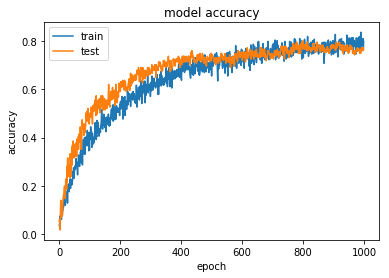

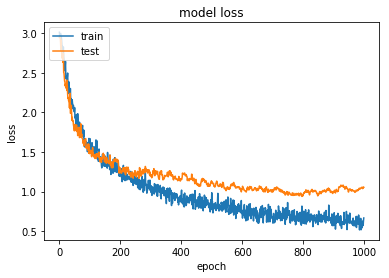

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()